In [2]:
import pandas as pd
import numpy as np

In [3]:

df_fronts_full = pd.read_excel(
    f"SI-data.xlsx", sheet_name="Front_rate-and-T_max")


df_fronts_full = df_fronts_full.astype({
    'Kraken_ID': str,
    'CAS': str,
    'SMILES': str,
    'Name': str,
    'DCPD': float,
    'ENB': float,
    'DHF': float,
    'T_max': float,
    'Front_rate_mm/s': float,
    'FROMP_worked': bool,
})

df_fronts_full = df_fronts_full.astype({
    'Kraken_ID': 'category',
    'CAS': 'category',
    'SMILES': 'category',
    'Name': 'category',
    'DCPD': float,
    'ENB': float,
    'DHF': float,
    'T_max': float,
    'Front_rate_mm/s': float,
    'FROMP_worked': 'category',  
})

In [4]:
# # TODO: look at CustomDataFrame class for better handling of dataframes i.e. full and avg.
# # TODO: is it better to do this to the full df then pull avg when needed?

def column_mover(df, list_columns_to_move, ref_column_str):
    # moves columns in list to the right of the ref column
    cols = df.columns.tolist()
    for column_to_move in list_columns_to_move:
        column = cols.pop(cols.index(column_to_move))
        cols.insert(cols.index(ref_column_str) + 1, column)
    df = df[cols]
    return df


def column_copier(df, list_columns_to_move, ref_column_str):
    # copies columns in list to the right of the ref column
    cols = df.columns.tolist()
    for column_to_move in list_columns_to_move:
        new_column_name = column_to_move + "_copy"
        df[new_column_name] = df[column_to_move]
        cols.insert(cols.index(ref_column_str) + 1, new_column_name)
    df = df[cols]
    return df

df_fronts_full_avg = df_fronts_full.dropna().groupby(['Kraken_ID', 'DHF', 'ENB'])['Front_rate_mm/s'].agg(
    ['mean', 'std']).reset_index()  # drops na and then groups by Kraken_ID, DHF, and ENB, then aggregates mean and std
df_fronts_full_avg.rename(
    columns={'mean': 'mean front rate, mm/s', 'std': 'std front rate'}, inplace=True)
df_fronts_full_avg = pd.merge(df_fronts_full_avg, df_fronts_full[[
                              'Kraken_ID', "Name", 'CAS', "SMILES"]].drop_duplicates(), on='Kraken_ID', how='left')

df_fronts_full_avg = column_mover(df_fronts_full_avg, list_columns_to_move=[
                                  'DHF', 'ENB'], ref_column_str="std front rate")  # used to identify conditions when exp values scaled
df_fronts_full_avg = column_copier(df_fronts_full_avg, list_columns_to_move=[
                                   'DHF', 'ENB'], ref_column_str='SMILES')  # creates a copy for scaling for model

tmp_df_kraken_data = pd.read_excel(
    f"SI-data.xlsx", sheet_name="Kraken_descriptor")
tmp_df_kraken_data['Kraken_ID'] = tmp_df_kraken_data['Kraken_ID'].astype(str)
df_fronts_full_avg = pd.merge(
    df_fronts_full_avg, tmp_df_kraken_data, on='Kraken_ID', how='left')
del tmp_df_kraken_data

# df_fronts_full_avg.to_pickle('df_fronts_full_avg-with_structures-and-kraken.pkl')

In [5]:
ext_ids = ['394', '488', '685', '2067'] # define external IDs to be to be withheld from the train/test split

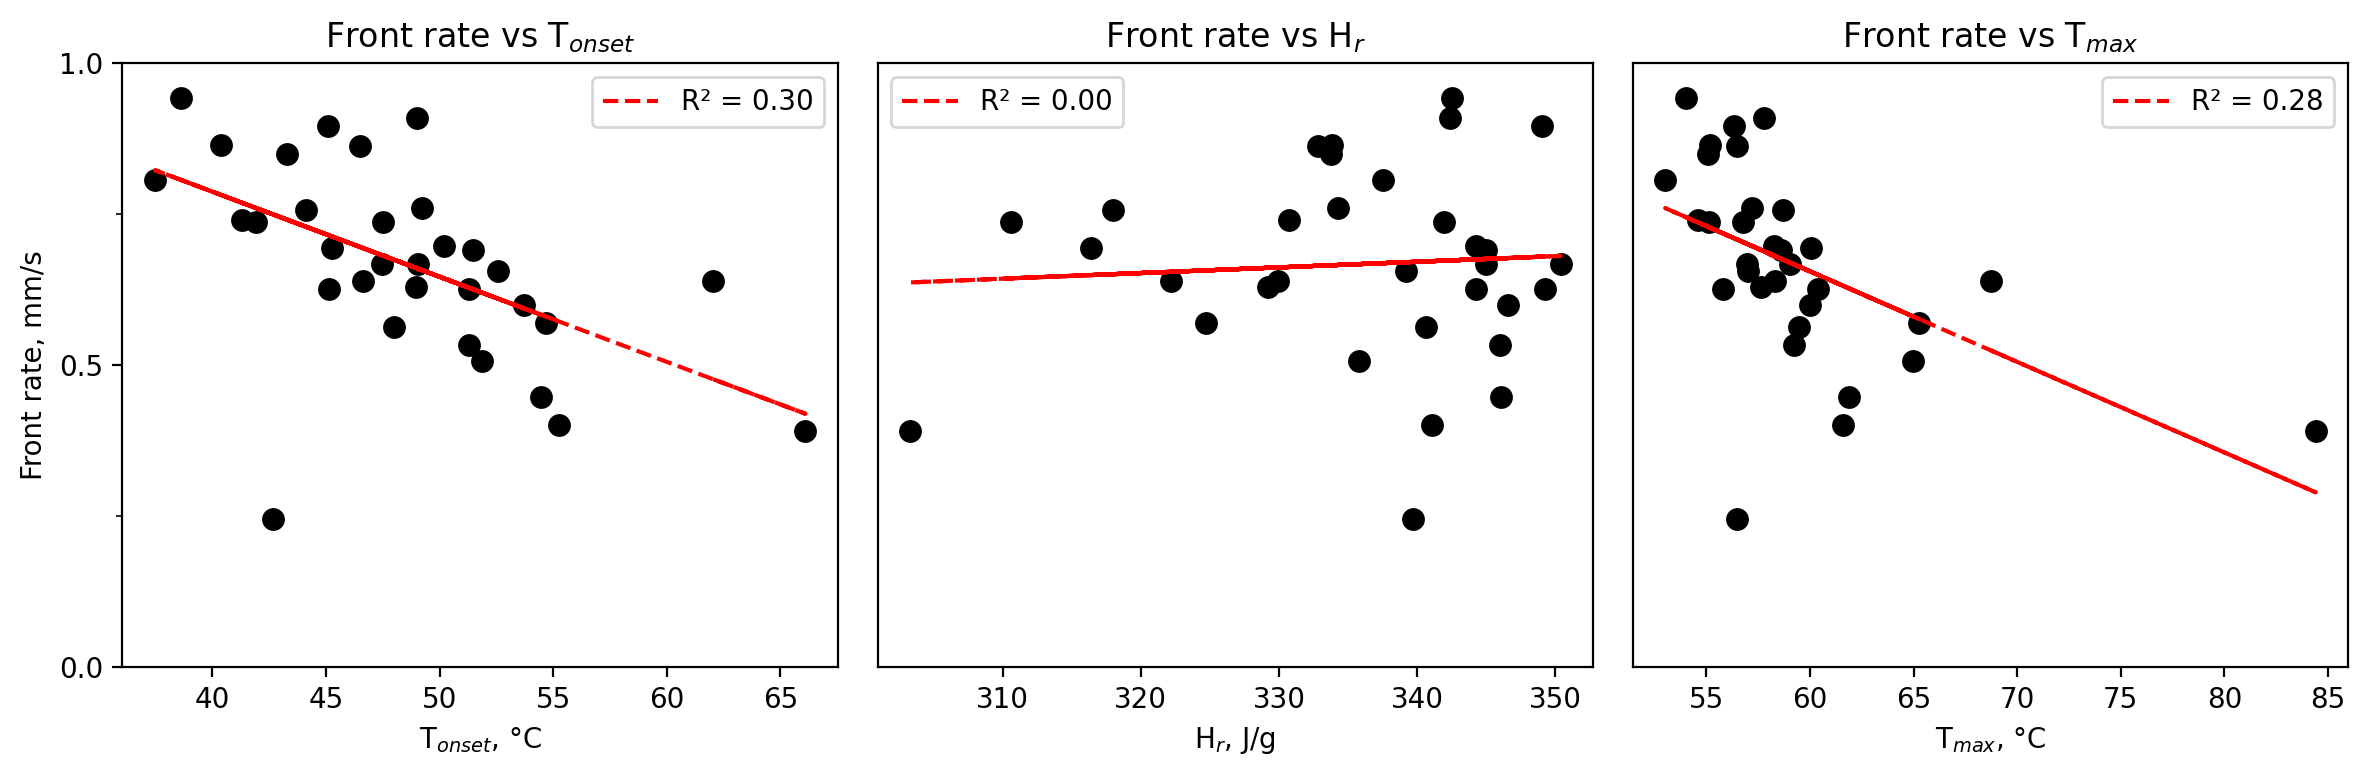

In [6]:
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import scipy.stats


df_dsc_data = pd.read_excel(
    f"SI-data.xlsx", sheet_name="DSC-cure") # import DSC data
df_dsc_data['Kraken_ID'] = df_dsc_data['Kraken_ID'].astype(str) # convert Kraken_ID to string
df_dsc_data = pd.merge(df_dsc_data[df_dsc_data['DHF'] == 0][['Kraken_ID','DHF','Tonset_mean','Hr_mean','Tmax_mean']], df_fronts_full_avg[(df_fronts_full_avg['DHF'] == 0) & (df_fronts_full_avg['ENB'] == 5)][['Kraken_ID','mean front rate, mm/s','CAS',"SMILES",'Name']], on='Kraken_ID', how='left') # merge DSC data with df_fronts_full_avg
df_dsc_data.dropna(inplace=True) # drop rows with NaN values
df_dsc_data = df_dsc_data.rename(columns={'Tonset_mean': 'T$_{onset}$','Hr_mean': 'H$_{r}$','Tmax_mean': 'T$_{max}$', 'mean front rate, mm/s': 'front rate, mm/s'}) # rename column
# df_dsc_data = df_dsc_data.drop(25)

my_dpi = 199
fig_dimensions = [4, 4]  # [fig_width, fig_height]
point_size = 60

ppt_conversion_x = 1  # 1.29
ppt_conversion_y = 1  # 1.33

fig_dimensions_conv = [fig_dimensions[0] *
                       ppt_conversion_x, fig_dimensions[1]*ppt_conversion_y]



x_axis_column_list = ['T$_{onset}$', 'H$_{r}$','T$_{max}$']
x_axis_units = ['°C', 'J/g', '°C']
y_axis = 'front rate, mm/s'
fig, axs = plt.subplots(1,len(x_axis_column_list), figsize=(fig_dimensions_conv[0]*len(x_axis_column_list), fig_dimensions_conv[1]), dpi=my_dpi, sharey=True)

ymin = 0
ymax = 1
base = 0.5

for i, x_axis in enumerate(x_axis_column_list):
    x = df_dsc_data[x_axis]
    y = df_dsc_data[y_axis]
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    
    # Calculate R-squared
    r_squared = r_value**2
    
    # Plot the data and the fitted line
    axs[i].scatter(x, y, s=point_size, c='black', edgecolor='black', linewidths=0.5)
    axs[i].plot(x, intercept + slope*x, "r--", label=f'R² = {r_squared:.2f}')
    
    axs[i].set_title(f'Front rate vs {x_axis}')
    axs[i].set_xlabel(x_axis + f', {x_axis_units[i]}')
    if i == 0:  # only set y label for the first subplot
        axs[i].set_ylabel('Front rate, mm/s')
    axs[i].set_ylim([ymin, ymax])
    axs[i].yaxis.set_major_locator(MultipleLocator(base))
    axs[i].yaxis.set_minor_locator(MultipleLocator(base/2))
    if i != 0:  # remove y axis for other subplots
        axs[i].yaxis.set_visible(False)
    
    axs[i].legend()

plt.tight_layout()
plt.show()

del fig, axs, my_dpi, fig_dimensions, point_size, ppt_conversion_x, ppt_conversion_y, fig_dimensions_conv, ymin, ymax, base
del df_dsc_data, i, intercept, p_value, r_squared, r_value, slope, std_err, x, x_axis, x_axis_column_list, x_axis_units, y, y_axis


In [7]:
# import types # for list_variables

# def list_variables():
#     # sorted list of all variable names in global scope
#     variable_names = [name for name, value in globals().items() if not callable(value) and not name.startswith("_") and not isinstance(value, types.ModuleType) and name not in ('In', 'Out')]
#     variable_names.sort()
#     print("\nVariables:")
#     # Print variable names
#     for name in variable_names:
#         print(" " + name)


# def list_functions():
#     # sorted list of all function names in global scope
#     function_names = [name for name, value in globals().items() if callable(value) and name not in ('get_ipython', 'exit', 'quit', 'open')]
#     function_names.sort()
#     # Print function names
#     print("\nFunctions:")
#     for name in function_names:
#         print(" " + name)

# list_variables()
# list_functions()


Variables:
 df_fronts_full
 df_fronts_full_avg
 ext_ids

Functions:
 MultipleLocator
 column_copier
 column_mover
 list_functions
 list_variables


In [8]:
# TODO: clean this cell up

first_descriptor_column = 'ENB_copy'

try:
    x_names = df_fronts_full_avg.columns.tolist()
    first_descriptor_index = x_names.index(first_descriptor_column)
    x_names = x_names[first_descriptor_index:] # creates a list of the descriptors
    x_labels = [f'x{i}' for i in range(1, len(x_names)+1)] # creates a list of x1, x2, x3, etc    
    x_label_dict = dict(zip(x_labels, x_names)) # used to switch the labels to the names (x###)
    x_names_dict = dict(zip(x_names, x_labels)) # used to switch the names to the labels (x###)
    df_fronts_full_avg.rename(columns=x_names_dict, inplace=True)

except ValueError:
    print(f'{first_descriptor_column} not found')
    print(f'The df columns may be x## form already')

try:
    x_names_keep = ['ENB_copy','DHF_copy','vbur_near_vtot_min', 'E_oxidation_boltz']
    x_labels_keep = [x_names_dict[x] for x in x_names_keep]
    x_labels_drop = [x for x in x_labels if x not in x_labels_keep]
    df_fronts_full_avg.drop(x_labels_drop, axis=1, inplace=True)
    x_labels = [col for col in df_fronts_full_avg.columns if col.startswith('x')] # updates x_labels list
    x_names = [x_label_dict[x] for x in x_labels] # updates x_names list
    x_label_dict = dict(zip(x_labels, x_names)) # used to switch the labels to the names (x###)
    x_names_dict = dict(zip(x_names, x_labels)) # used to switch the names to the labels (x###)
    print('Columns dropped')

except NameError:
    print('x_labels not defined')
except KeyError:
    print('Columns already dropped')

del x_labels_drop, x_labels_keep, x_names_keep,  #first_descriptor_column, first_descriptor_index,

Columns dropped

Variables:
 df_fronts_full
 df_fronts_full_avg
 ext_ids
 first_descriptor_column
 first_descriptor_index
 x_label_dict
 x_labels
 x_names
 x_names_dict

Functions:
 MultipleLocator
 column_copier
 column_mover
 list_functions
 list_variables


In [9]:
resp_label = 'mean front rate, mm/s'
verbose = True

data_set_description pre-split:
	Shape X: (515, 4)
	Shape y: (515,)
	Shape labels: (515,)
	First X cell: 5.0
	Last X cell:  375.195514416311
	First y: 0.6900000000000001
	Last y:  1.18
	ast label: 785

data_set_description post-split:
	Validation set ratio: 0.2
	Training set
	 shape: (396, 14)
	 unique Kraken_IDs: 22
	Validation set:
	 shape: (108, 14)
	 unique Kraken_IDs: 6
	External set:
	 shape: (180, 14)
	 unique Kraken_IDs: 10


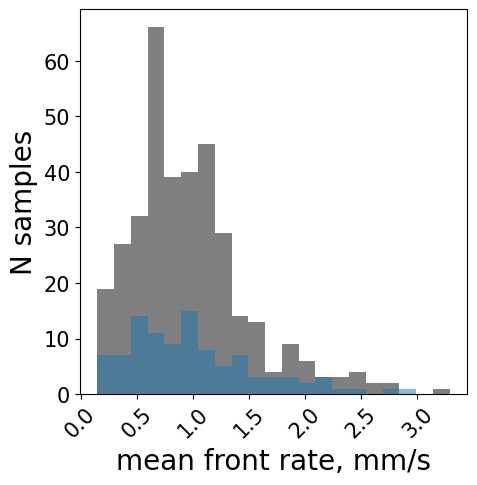

In [11]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt


x = df_fronts_full_avg[df_fronts_full_avg.notna().all(axis=1)][x_labels]
y = df_fronts_full_avg[df_fronts_full_avg.notna().all(axis=1)][resp_label]
id_labels =  df_fronts_full_avg[df_fronts_full_avg.notna().all(axis=1)]['Kraken_ID']

if verbose:
    print("data_set_description pre-split:")
    print(f"\tShape X: {x.shape}")
    print(f"\tShape y: {y.shape}")
    print(f"\tShape labels: {id_labels.shape}")
    print(f"\tFirst X cell: {x.iloc[0,0]}")
    print(f"\tLast X cell:  {x.iloc[-1,-1]}")
    print(f"\tFirst y: {y.iloc[0]}")
    print(f"\tLast y:  {y.iloc[-1]}")
    print(f"\tast label: {id_labels.iloc[-1]}")

VS = ['2060', '143', '453', '660', '138', '651']  # kraken IDs that were selected randomly for the validation set

df_fronts_full_avg['split'] = 'TS'
df_fronts_full_avg['split'] = df_fronts_full_avg['split'].astype('category')
df_fronts_full_avg['split'] = df_fronts_full_avg['split'].cat.add_categories(["VS", "EX"])
df_fronts_full_avg['scaled'] = False
df_fronts_full_avg.loc[df_fronts_full_avg['Kraken_ID'].isin(VS), 'split'] = 'VS'
df_fronts_full_avg.loc[df_fronts_full_avg['Kraken_ID'].isin(ext_ids), 'split'] = "EX"


scaler = StandardScaler()


train_filter = df_fronts_full_avg['split'] == 'TS'
test_filter = df_fronts_full_avg['split'] == 'VS'
not_train_filter = df_fronts_full_avg['split'] != 'TS'

# set the scaler to the training set and apply to the test set
df_fronts_full_avg.loc[train_filter, x_labels] = scaler.fit_transform(
    df_fronts_full_avg.loc[train_filter, x_labels])
df_fronts_full_avg.loc[train_filter, 'scaled'] = True
df_fronts_full_avg.loc[test_filter, x_labels] = scaler.transform(
    df_fronts_full_avg.loc[test_filter, x_labels])
tmp_test = scaler.transform(
    df_fronts_full_avg.loc[test_filter, x_labels])
df_fronts_full_avg.loc[test_filter, 'scaled'] = True


counts = df_fronts_full_avg['split'].value_counts()
test_ratio = np.around(
    counts['VS'] / (counts['VS'] + counts['TS']), decimals=1)

if verbose:
    print("\ndata_set_description post-split:")
    print(f"\tValidation set ratio: {test_ratio}")
    print("\tTraining set")
    print(f"\t shape: {df_fronts_full_avg[train_filter].shape}")
    print(f"\t unique Kraken_IDs: {df_fronts_full_avg[train_filter]['Kraken_ID'].nunique()}")

    print("\tValidation set:")
    print(f"\t shape: {df_fronts_full_avg[test_filter].shape}")
    print(f"\t unique Kraken_IDs: {df_fronts_full_avg[test_filter]['Kraken_ID'].nunique()}")

    print("\tExternal set:")
    print(f"\t shape: {df_fronts_full_avg[not_train_filter].shape}")
    print(f"\t unique Kraken_IDs: {df_fronts_full_avg[not_train_filter]['Kraken_ID'].nunique()}")

    plt.figure(figsize=(5, 5))
    hist, bins = np.histogram(y, bins="auto")  # "auto"
    plt.hist(df_fronts_full_avg.loc[train_filter][resp_label],
            bins, alpha=0.5, label='y_train', color="black")
    plt.hist(df_fronts_full_avg.loc[test_filter]
            [resp_label], bins, alpha=0.5, label='y_test')

    # can display kraken_ID: indices
    # pd.set_option('display.max_colwidth', None)
    # kraken_id_indices = df_fronts_full_avg.loc[train_filter].groupby(['Kraken_ID']).apply(lambda x: x.index.tolist())
    # print(kraken_id_indices)
    # plt.legend(loc='best')

    plt.xlabel(resp_label, fontsize=20)
    # plt.xlabel("y",fontsize=20)
    plt.ylabel("N samples", fontsize=20)
    plt.xticks(fontsize=15, rotation=45)
    plt.yticks(fontsize=15)
    plt.show()

del x, y, id_labels, counts, hist, bins, test_filter, train_filter, not_train_filter, test_ratio, tmp_test, VS, ext_ids, first_descriptor_column, first_descriptor_index


In [13]:
df_fronts_tmp = df_fronts_full_avg.loc[(df_fronts_full_avg['DHF'] == 0) & (
    df_fronts_full_avg['ENB'] == 5), ['Kraken_ID', 'mean front rate, mm/s']]
df_fronts_tmp['Kraken_ID'] = df_fronts_tmp['Kraken_ID'].astype(str)
df_kraken_merged_tmp = pd.read_excel(
    f'/mnt/c/Users/tmcfa/PycharmProjects/FROMP-GUI/df_kraken_merged.xlsx')
df_kraken_merged_tmp = df_kraken_merged_tmp[[
    'Kraken_ID', 'mean pot_life, hours']]
df_kraken_merged_tmp['Kraken_ID'] = df_kraken_merged_tmp['Kraken_ID'].astype(
    str)
df_fronts_and_pot_life = pd.merge(
    df_kraken_merged_tmp, df_fronts_tmp, on='Kraken_ID', how='left')
del df_fronts_tmp, df_kraken_merged_tmp

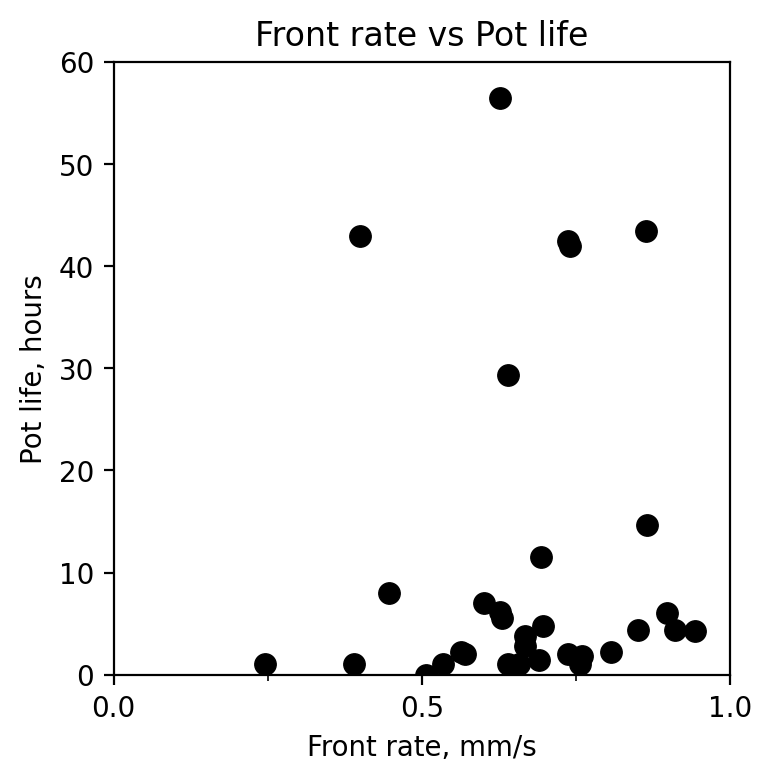

In [15]:
from matplotlib.ticker import MultipleLocator
my_dpi = 199
fig_dimensions = [4, 4]  # [fig_width, fig_height]
point_size = 60

ppt_conversion_x = 1  # 1.29
ppt_conversion_y = 1  # 1.33

fig_dimensions_conv = [fig_dimensions[0] *
                       ppt_conversion_x, fig_dimensions[1]*ppt_conversion_y]


fig, ax = plt.subplots(
    figsize=(fig_dimensions_conv[0], fig_dimensions_conv[1]), dpi=my_dpi)

ax.scatter(df_fronts_and_pot_life['mean front rate, mm/s'], df_fronts_and_pot_life['mean pot_life, hours'],
           s=point_size, c='black', edgecolor='black', linewidths=0.5)
# ax = sns.scatterplot(x=df_fronts_and_pot_life['mean front rate, mm/s'], y=df_fronts_and_pot_life['mean pot_life, hours'], size=point_size)
ax.set_title('Front rate vs Pot life')
ax.set_ylabel('Pot life, hours')
ax.set_xlabel('Front rate, mm/s')


xmin = 0
xmax = 1
base = 0.5

ax.set_xlim([xmin, xmax])
ax.set_ylim([0, 60])

ax.xaxis.set_major_locator(MultipleLocator(base))
ax.xaxis.set_minor_locator(MultipleLocator(base/2))


plt.show()
del fig, ax, my_dpi, fig_dimensions, point_size, ppt_conversion_x, ppt_conversion_y, fig_dimensions_conv, xmin, xmax, base
del df_fronts_and_pot_life

In [17]:
from numpy.polynomial import Polynomial
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, to_rgba


# TODO: clean this function up
def single_plot(df, kraken_ids, y_label='mean front rate, mm/s', x_label='ENB', groupby='dhf', ax=None, legend=True, label_suffix='', color_map='tab10', y_error='std front rate', x_units=None, x_range=None, y_range=None, title=None, color_list=None, point_size=60, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    # Create a list of unique ids
    unique_ids = []
    for kraken_id in kraken_ids:
        if isinstance(kraken_id, tuple):
            unique_ids.append(kraken_id[0])
        else:
            unique_ids.append(kraken_id)

    # # Generate a color map based on the number of unique groups
    # # grouped = df[df['Kraken_ID'].isin(unique_ids)].groupby(groupby)
    # grouped = df[df['Kraken_ID'].isin(kraken_ids)].groupby(groupby)
    # color_map = cm.get_cmap('Accent', len(grouped))
    # # Get the 'Accent' colormap
    cmap = cm.get_cmap(color_map)
    # Create a darker version of the colormap
    dark_cmap = ListedColormap([to_rgba(c, alpha=0.1) for c in cmap.colors])

    # Use the darker colormap
    color_map = dark_cmap

    if x_range is None:
        fit_range = (df[x_label].min(), df[x_label].max())
        x_range = (df[x_label].min(), df[x_label].max())
    else:
        if (x_label == 'ENB') & (x_range[0] < 0):
            fit_range = (0, x_range[1])
            if x_range[1] > 100:
                x_range = (x_range[0], 100)
        elif (x_label == 'ENB') & (x_range[1] > 100):
            fit_range = (x_range[0], 100)
        else:
            fit_range = (x_range[0], x_range[1])

    fit_line_style = '--'
    fit_line_alpha = 0.5
    error_alpha = 0.5

    for i, kraken_id in enumerate(kraken_ids):
        # Get a color from the color map
        color = color_map(i / len(kraken_ids))
        if color_list and len(color_list) % len(kraken_ids) == 0:
            color = color_list[i]

        if isinstance(kraken_id, tuple):
            id, split_value = kraken_id
            group = df[df['Kraken_ID'] == id]

            # Extract y-error values from the DataFrame
            yerr = group[y_error]

            # Plot the error bars
            # ax.errorbar(group[x_label], group[y_label], yerr=yerr, fmt='none', ecolor=color, alpha=error_alpha, **kwargs)

            # Plot the points
            ax.scatter(group[x_label], group[y_label], label=f"{label_suffix}{id}", color=color,
                       edgecolor='black', linewidths=0.5, alpha=1.0, s=point_size, **kwargs)

            # Fit a line to the data for x less than split_value
            mask = group[x_label] < split_value
            p1 = Polynomial.fit(group[x_label][mask], group[y_label][mask], 1)
            x1 = p1.linspace(100, [fit_range[0], split_value])[0]
            ax.plot(x1, p1(x1), color=color, linestyle=fit_line_style,
                    linewidth=2.5, alpha=fit_line_alpha)

            # Fit a line to the data for x greater than or equal to split_value
            mask = group[x_label] >= split_value
            p2 = Polynomial.fit(group[x_label][mask], group[y_label][mask], 1)
            x2 = p2.linspace(100, [split_value, fit_range[1]])[0]
            ax.plot(x2, p2(x2), color=color, linestyle=fit_line_style,
                    linewidth=2.5, alpha=fit_line_alpha)
        else:
            group = df[df['Kraken_ID'] == kraken_id]

            try:
                # Extract y-error values from the DataFrame
                yerr = group[y_error]
            except:
                yerr = None
                print(f"Could not extract y-error values for {kraken_id}")

            # Plot the error bars
            # ax.errorbar(group[x_label], group[y_label], yerr=yerr, fmt='none', ecolor=color, alpha=error_alpha, **kwargs)

            # Plot the points
            ax.scatter(group[x_label], group[y_label], label=f"{label_suffix}{kraken_id}",
                       color=color, edgecolor='black', alpha=1.0, linewidths=0.5, s=60, **kwargs)

            try:
                # Fit a line to the data
                p = Polynomial.fit(group[x_label], group[y_label], 1)
                x = p.linspace(100, fit_range)[0]
                ax.plot(x, p(x), color=color, linestyle=fit_line_style,
                        linewidth=2.5, alpha=fit_line_alpha)
            except:
                print(f"Could not fit line to {kraken_id}")
                pass

    if x_units is None:
        ax.set_xlabel(x_label)
    else:
        ax.set_xlabel(f"{x_label}, {x_units}")

    ax.set_ylabel(y_label)
    if legend:
        ax.legend(title=groupby)

    # Set x-axis range
    if x_range is not None:
        ax.set_xlim(x_range)

    # Set y-axis range
    if y_range is not None:
        ax.set_ylim(y_range)

    # Set tick parameters
    # ax.tick_params(axis='both', direction='in', which='both', top=True, right=True)

    if title is not None:
        ax.set_title(title)

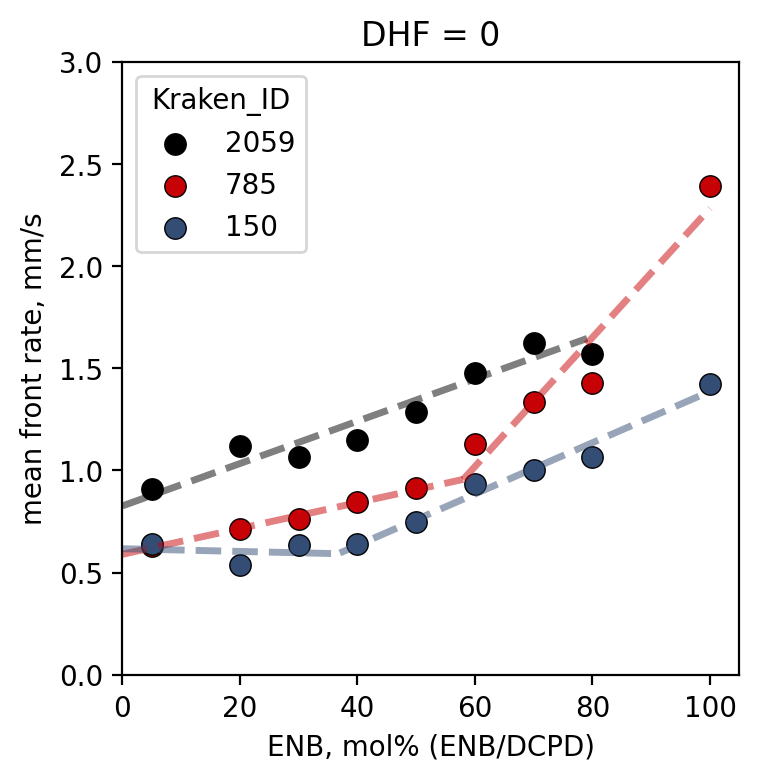

In [19]:
df_non_linear_plot = df_fronts_full_avg
DHF_value = 0
point_size = 60
my_dpi = 199
fig_dimensions = [4, 4]  # [fig_width, fig_height]
ppt_conversion_x = 1  # 1.29
ppt_conversion_y = 1  # 1.33

fig_dimensions_conv = [fig_dimensions[0] *
                       ppt_conversion_x, fig_dimensions[1]*ppt_conversion_y]

df_non_linear_plot = df_non_linear_plot[df_non_linear_plot['DHF'] == DHF_value]


if DHF_value == 0:
    # , ("454",40), ("658",78), ("149", 60)] #DHF=0, TBP
    Kraken_ID_list = [("2059", 79.1), ("785", 58), ("150", 37)]
    # Kraken_ID_list = [("2059", 70), ("785",58),("2065",53), ("454",40), ("658",78), ("149", 60)] #DHF=0
    # Kraken_ID_list = [("2065",53)] #DHF=0
else:
    # Kraken_ID_list = ["2059", ("785",68),"150", "454", "658", ("149",70) ] #DHF=10 TBP
    # ["2059", ("785",68),("2065",80), "454", "658", ("149",70) ] #DHF=10
    Kraken_ID_list = [("2059", 70), ("785", 68), ("150", 37)]
fig, ax = plt.subplots(
    figsize=(fig_dimensions_conv[0], fig_dimensions_conv[1]), dpi=my_dpi)

colors = plt.get_cmap('coolwarm')(np.linspace(
    0, 1, df_non_linear_plot['DHF'].nunique()))
color_map = dict(zip(df_non_linear_plot['DHF'].unique(), colors))

# if DHF_value == 0:
#     x_range = [0,105]
# else:
#     x_range = [0,100]


single_plot(df_non_linear_plot, Kraken_ID_list, 'mean front rate, mm/s', color_list=['#000000', '#c60206', '#334d75'], groupby='Kraken_ID', y_error='std front rate', x_range=[
            0, 105], y_range=[0, 3], x_units='mol% (ENB/DCPD)', ax=ax, title=f'DHF = {DHF_value}', point_size=60)


plt.show()
del df_non_linear_plot, DHF_value, point_size, my_dpi, fig_dimensions, ppt_conversion_x, ppt_conversion_y, fig_dimensions_conv, Kraken_ID_list, colors, color_map, ax, fig

In [21]:
# TODO: combine this with the other plotting function
def plot_fit(y_train, y_pred_train, y_test, y_pred_test, leg=True, save=False, label="y", loo_pred=[], loo_label='LOO', x_rotation=45, fig_dimensions=[3, 3], additional_points=[], additional_points_pred=[], additional_points_color=[], additional_points_label=[], legend_loc='lower right', pad=0):
    y_orig_min = np.min(np.hstack((y_train, y_test)))
    y_pred_min = np.min(np.hstack((y_pred_train, y_pred_test)))
    y_orig_max = np.max(np.hstack((y_train, y_test)))
    y_pred_max = np.max(np.hstack((y_pred_train, y_pred_test)))
    delta_x = 0.04 * (y_orig_max-y_orig_min)
    delta_y = 0.04 * (y_pred_max-y_pred_min)

    yy_fit = np.polyfit(y_train, y_pred_train, deg=1)
    yy_fit_line = yy_fit[1]+yy_fit[0]*y_train

    # figsize_scalar = 10
    my_dpi = 199
    fig_dimensions = fig_dimensions  # [fig_width, fig_height]

    ppt_conversion_x = 1.29
    ppt_conversion_y = 1.33

    fig_dimensions_conv = [fig_dimensions[0] *
                           ppt_conversion_x, fig_dimensions[1]*ppt_conversion_y]
    fig_height_ratio = [fig_dimensions_conv[1]-fig_dimensions_conv[0] /
                        2, fig_dimensions_conv[0]/2]  # based off 2:1 ratio of image

    # figsize=(5,5))
    plt.figure(
        figsize=(fig_dimensions_conv[0], fig_dimensions_conv[1]), dpi=my_dpi)

    # fig, ax = plt.subplots(figsize=(fig_dimensions_conv[0],fig_dimensions_conv[1]), dpi=my_dpi))

    y_min_min = min(y_orig_min-delta_x, y_pred_min-delta_y)
    y_max_max = max(y_orig_max+delta_x, y_pred_max+delta_y) + pad

    plt.xlim([y_min_min, y_max_max])
    plt.ylim([y_min_min, y_max_max])
    if len(loo_pred) != 0:
        plt.scatter(y_train, loo_pred, label=loo_label, color="black",
                    marker=".", facecolor='none', s=100, linewidth=0.5) 
    plt.scatter(y_train, y_pred_train, label="Train",
                color="black", marker=".", s=100) # ,alpha=0.6
    plt.scatter(y_test, y_pred_test, label="Test", color=('#c94265'), marker=".",
                linewidth=0.2, s=200, edgecolors='black')  # ,alpha=0.25  "#8da9f5"
    plt.plot(y_train, yy_fit_line, color="darkgrey",
             linestyle='--', dashes=[5, 15])  # ,alpha=0.2

    if len(additional_points) != 0:
        plt.scatter(additional_points, additional_points_pred, label=additional_points_label,
                    color=additional_points_color, marker=".", s=200, edgecolors='black', linewidth=0.2) # ,alpha=0.25  "#8da9f5"

    if leg:
        plt.legend(loc=legend_loc)
    plt.xlabel(f"Measured {label}")
    plt.ylabel(f"Predicted {label}")

    plt.xticks(rotation=x_rotation)
    ticks = np.arange(int(y_min_min), int(np.ceil(y_max_max)), 1)

    # Set the same ticks for both x and y axes
    plt.xticks(ticks)
    plt.yticks(ticks)

    # plt.gca().spines['right'].set_color('none')
    # plt.gca().spines['top'].set_color('none')

    if not save:
        plt.show()
    else:
        plt.savefig(save, dpi=300, bbox_inches='tight', transparent=True)

In [22]:
def r2_val(y_test, y_pred_test, y_train):
    """Calculates the external R2 pred as described:
    https://pdfs.semanticscholar.org/4eb2/5ff5a87f2fd6789c5b9954eddddfd1c59dab.pdf"""
    y_residual = y_pred_test - y_test
    SS_residual = np.sum(y_residual**2)
    y_var = y_test - np.mean(y_train)
    SS_total = np.sum(y_var**2)
    r2_validation = 1-SS_residual/SS_total
    return (r2_validation)

Validation set ratio: 0.21

KernelRidge



00  alpha: 0.01; Training R2: 0.99; Training Q2: 0.71; Test R2: 0.79
Training MAE: 0.03; Test MAE: 0.19; diff: -0.16

01  alpha: 0.11; Training R2: 0.96; Training Q2: 0.74; Test R2: 0.81
Training MAE: 0.07; Test MAE: 0.18; diff: -0.11

02  alpha: 0.21; Training R2: 0.95; Training Q2: 0.74; Test R2: 0.81
Training MAE: 0.08; Test MAE: 0.18; diff: -0.10

03  alpha: 0.31; Training R2: 0.94; Training Q2: 0.75; Test R2: 0.80
Training MAE: 0.09; Test MAE: 0.18; diff: -0.10

04  alpha: 0.41; Training R2: 0.93; Training Q2: 0.75; Test R2: 0.80
Training MAE: 0.09; Test MAE: 0.19; diff: -0.09

05  alpha: 0.51; Training R2: 0.92; Training Q2: 0.75; Test R2: 0.80
Training MAE: 0.10; Test MAE: 0.19; diff: -0.09

06  alpha: 0.61; Training R2: 0.92; Training Q2: 0.75; Test R2: 0.80
Training MAE: 0.10; Test MAE: 0.19; diff: -0.09

07  alpha: 0.71; Training R2: 0.91; Training Q2: 0.75; Test R2: 0.79
Training MAE: 0.11; Test MAE: 0.19; diff: -0.08

08  alpha: 0.81; Training R2: 0.91; Training Q2: 0.75; T

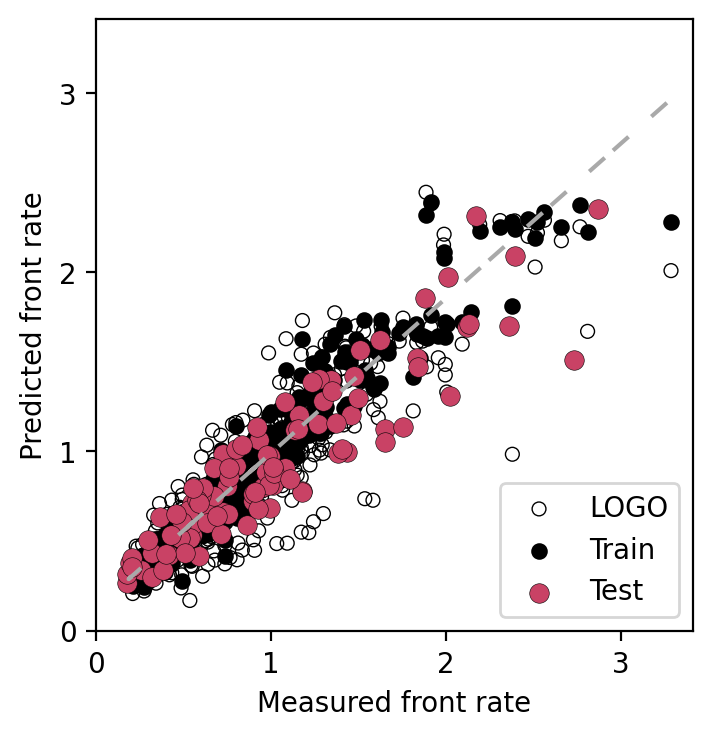

In [24]:
from sklearn.model_selection import LeaveOneOut, cross_val_predict, LeaveOneGroupOut
from sklearn.kernel_ridge import KernelRidge
import loo_q2 as loo
# Kernel Ridge Regression
# kernel options: linear, poly, rbf

# TODO: store in df at end rather then lists? Can make a dict using the alpha values as keys

# df_fronts_full_avg = df_fronts_full_avg.dropna()
vs_count = df_fronts_full_avg[df_fronts_full_avg['split'] == 'VS']['Kraken_ID'].nunique()
ts_count = df_fronts_full_avg[df_fronts_full_avg['split'] == 'TS']['Kraken_ID'].nunique()
test_ratio = vs_count / (vs_count + ts_count)
print(f"Validation set ratio: {test_ratio:.2f}")

r2s = []
q2s = []
parameter_list = []
loo_trains = []
y_pred_tests = []
y_pred_trains = []
krs = []
train_r2_list = []
test_r2_list = []
train_mae_list = []
test_mae_list = []
mae_difference_list = []


def df_to_np_arrays(df, x_labels, resp_label, external=False):
    """Converts a dataframe to numpy arrays for use in sklearn models. Returns X_train_sc, y_train, X_test_sc, y_test, ts_group_list"""
    # Temporarily remove 'y_pred' column before dropping NaN rows to avoid errors when rerunning with ext data
    df_temp = df.drop(columns='y_pred') if 'y_pred' in df.columns else df
    df = df_temp.dropna()
    index_used_list = df.index

    X_train_sc = df.loc[df['split'] == 'TS', x_labels].to_numpy()
    y_train = df.loc[df['split'] == 'TS'][resp_label].to_numpy()
    X_test_sc = df.loc[df['split'] == 'VS', x_labels].to_numpy()
    y_test = df.loc[df['split'] == 'VS'][resp_label].to_numpy()
    ts_group_list = df.loc[df['split'] == 'TS']['Kraken_ID'].to_numpy()
    if external:
        if False in df_fronts_full_avg[df_fronts_full_avg['split'] == 'EX']['scaled'].unique():
            raise ValueError("scale the EX x-values in df")
        X_ext_sc = df.loc[df['split'] == 'EX', x_labels].to_numpy()
        y_ext = df.loc[df['split'] == 'EX'][resp_label].to_numpy()
        return X_train_sc, y_train, X_test_sc, y_test, ts_group_list, index_used_list, X_ext_sc, y_ext
    else:
        return X_train_sc, y_train, X_test_sc, y_test, ts_group_list, index_used_list


X_train_sc, y_train, X_test_sc, y_test, ts_group_list, index_used_list = df_to_np_arrays(
    df_fronts_full_avg, x_labels, resp_label)

print("\nKernelRidge\n")

# laplacian "poly" #rbf (only works if properties are related) # 'linear', 'chi2', 'laplacian', 'polynomial', 'poly', 'additive_chi2', 'sigmoid', 'cosine', 'rbf', 'precomputed'
kernel = 'laplacian'
degree = 2  # 2 simulates cross terms

# parm_range = np.logspace(-3,3,7)
# np.linspace(0.1,2,7) #np.linspace(1.5,2,7)
parm_range = np.arange(start=0.01, stop=10, step=0.1)
# parm_range = [0.41]

# parm_range = np.arange(start=0.96, stop=1.1, step=0.001)  #np.linspace(0.1,2,7) #np.linspace(1.5,2,7)
i = 0
i_max = len(parm_range) - 1
pad = len(str(i_max))


for parm in parm_range:
    # print(parm)
    kr = KernelRidge(
        kernel=kernel,
        degree=degree,
        alpha=parm,
    ).fit(X_train_sc, y_train)
    # print(f'score test: {kr.score(X_train_sc, y_train)}')
    train_r2 = kr.score(X_train_sc, y_train)

    y_pred_test = kr.predict(X_test_sc)
    y_pred_train = kr.predict(X_train_sc)

    # q2,loo_train = loo.q2(X_train_sc,y_train,KernelRidge(kernel=kernel,degree=degree,alpha=parm))

    # q2,loo_train = loo.q2_group(X_train_sc,y_train,ts_group_list,kr)
    q2, loo_train = loo.q2_group(X_train_sc, y_train, ts_group_list, KernelRidge(
        kernel=kernel, degree=degree, alpha=parm))
    # q2,loo_train = loo.q2(X_train_sc,y_train,KernelRidge(kernel=kernel,degree=degree,alpha=parm))

    test_r2 = r2_val(y_test, y_pred_test, y_train)
    print(f"{str(i).zfill(pad)}  alpha: {parm:.2f}; Training R2: {train_r2:.2f}; Training Q2: {q2:.2f}; Test R2: {test_r2:.2f}")
    r2s.append(kr.score(X_train_sc, y_train))
    q2s.append(q2)
    parameter_list.append(parm)
    loo_trains.append(loo_train)
    y_pred_tests.append(y_pred_test)
    y_pred_trains.append(y_pred_train)
    krs.append(kr)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

    train_mae_list.append(np.abs(y_train - y_pred_train).mean())
    test_mae_list.append(np.abs(y_test - y_pred_test).mean())
    mae_difference_list.append(train_mae_list[-1] - test_mae_list[-1])
    print(
        f"Training MAE: {train_mae_list[-1]:.2f}; Test MAE: {test_mae_list[-1]:.2f}; diff: {mae_difference_list[-1]:.2f}\n")

    # plot_fit(y_train,y_pred_train,y_test,y_pred_test,label='Front rate',loo_pred=loo_train)

    # plot_fit(y_train,y_pred_train,y_test,y_pred_test,loo_pred=loo_train)
    i += 1

best_parameter_idx = np.where(q2s == np.max(q2s))[0][0]
best_parameter = parameter_list[best_parameter_idx]


print(f"\nUsing hyperparameter = {best_parameter_idx}   alpha: {best_parameter:.2f}")

# kr = KernelRidge(
#         kernel=kernel,
#         degree=degree,
#         alpha=best_parameter
#     ).fit(X_train_sc, y_train)

kr = krs[best_parameter_idx]


q2 = q2s[best_parameter_idx]
loo_train = loo_trains[best_parameter_idx]
y_pred_train = y_pred_trains[best_parameter_idx]

y_pred_test = y_pred_tests[best_parameter_idx]
test_r2 = test_r2_list[best_parameter_idx]
train_r2 = train_r2_list[best_parameter_idx]

print(
    f"Training R2: {train_r2:.2f}; Training Q2: {q2:.2f}; Test R2: {test_r2:.2f}")

# plot_fit(y_train,y_pred_train,y_test,y_pred_test,loo_pred=loo_train)

# q2,loo_train = loo.q2_group(X_train_sc,y_train,KernelRidge(kernel=kernel,degree=degree,alpha=best_parameter))


plot_fit(y_train, y_pred_train, y_test, y_pred_test, label='front rate',
         loo_pred=loo_train, loo_label='LOGO', x_rotation=0)

df_fronts_full_avg[f'y_pred'] = np.nan
# df_fronts_full_avg.loc[df_fronts_full_avg['split']
#                        == 'TS', 'y_pred'] = y_pred_train
# df_fronts_full_avg.loc[df_fronts_full_avg['split']
#                        == 'VS', 'y_pred'] = y_pred_test

df_fronts_full_avg.loc[(df_fronts_full_avg.index.isin(index_used_list)) & (df_fronts_full_avg['split'] == 'TS'), 'y_pred'] = y_pred_train
df_fronts_full_avg.loc[(df_fronts_full_avg.index.isin(index_used_list)) & (df_fronts_full_avg['split'] == 'VS'), 'y_pred'] = y_pred_test


del X_train_sc, X_test_sc, ts_group_list, q2, loo_train, y_pred_train, y_pred_test, test_r2, train_r2, degree, i, i_max, kernel, pad, parm, parm_range, test_ratio, ts_count, vs_count


Using hyperparameter = 0.61


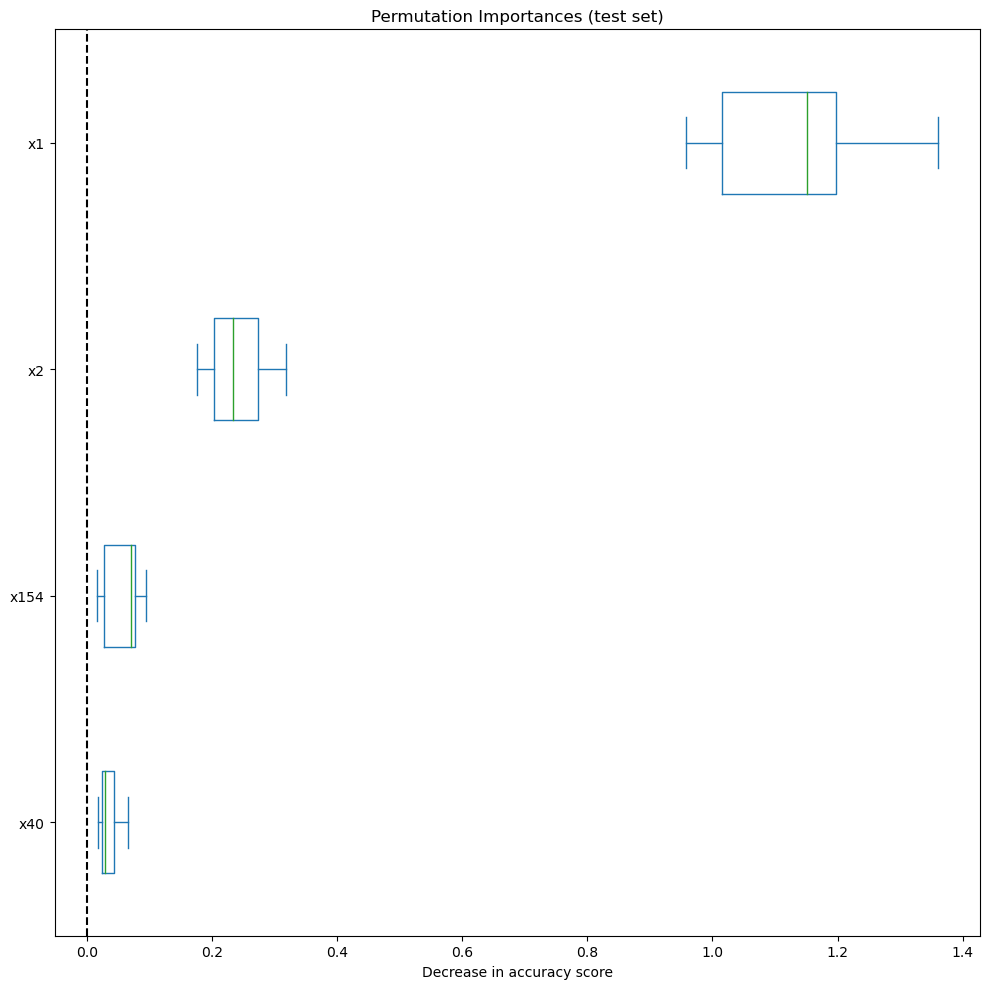

In [27]:
X_train_sc, y_train, X_test_sc, y_test, ts_group_list, index_used_list = df_to_np_arrays(
    df_fronts_full_avg, x_labels, resp_label)

from sklearn.inspection import permutation_importance
print(f"\nUsing hyperparameter = {best_parameter:.2F}")

result = permutation_importance(
    kr, X_test_sc, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    #TODO: why is 1D numpy array required here? .ravel flattens into 1D array
    columns=np.array(x_labels).ravel()[sorted_importances_idx],
)

ax = importances.iloc[:,:20].plot.box(vert=False, whis=10, figsize=(10, 10))
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


Using hyperparameter = 0.61
scaled False found in external data
ext data scaled
Training R2: 0.92; Training Q2: 0.75; Test R2: 0.80; External R2: 0.67


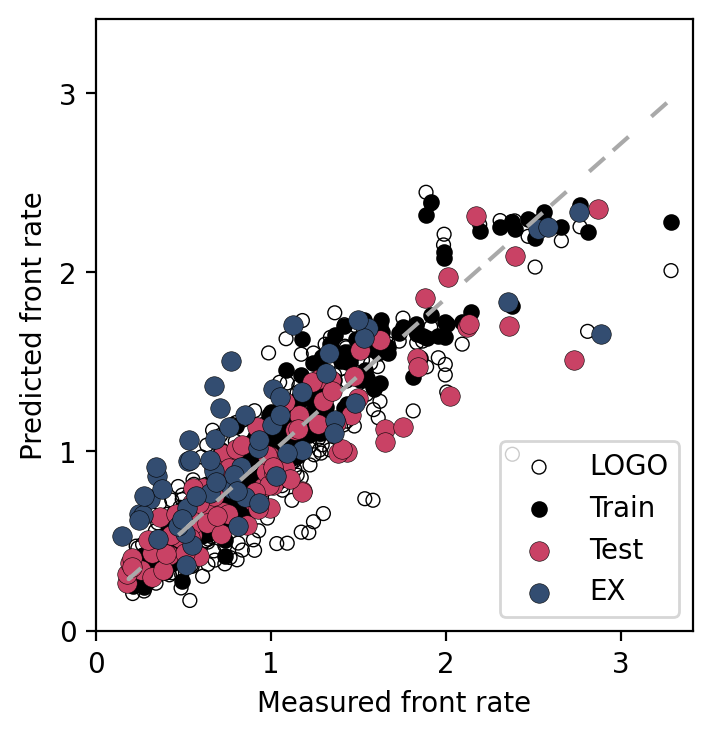

In [29]:
best_parameter = parameter_list[best_parameter_idx]
print(f"\nUsing hyperparameter = {best_parameter:.2F}")
kr = krs[best_parameter_idx]

if False in df_fronts_full_avg[df_fronts_full_avg['split'] == 'EX']['scaled'].unique():
    print('scaled False found in external data')
    df_fronts_full_avg.loc[(df_fronts_full_avg['split'] == 'EX') & (df_fronts_full_avg['scaled'] == False), x_labels] = scaler.transform(
        df_fronts_full_avg[(df_fronts_full_avg['split'] == 'EX') & (df_fronts_full_avg['scaled'] == False)][x_labels])
    df_fronts_full_avg.loc[df_fronts_full_avg['split']
                           == 'EX', 'scaled'] = True
    print("ext data scaled")


_, y_train, _, y_test, _, index_used_list, X_ext_sc, y_ext = df_to_np_arrays(
    df_fronts_full_avg, x_labels, resp_label, external=True)

y_ext_pred = kr.predict(X_ext_sc)
df_fronts_full_avg.loc[(df_fronts_full_avg.index.isin(index_used_list)) & (df_fronts_full_avg['split'] == 'EX'), 'y_pred'] = y_ext_pred

ext_rsq = r2_val(y_ext, y_ext_pred, y_train)

q2 = q2s[best_parameter_idx]
loo_train = loo_trains[best_parameter_idx]
y_pred_train = y_pred_trains[best_parameter_idx]
y_pred_test = y_pred_tests[best_parameter_idx]
test_r2 = test_r2_list[best_parameter_idx]
train_r2 = train_r2_list[best_parameter_idx]

print(
    f"Training R2: {train_r2:.2f}; Training Q2: {q2:.2f}; Test R2: {test_r2:.2f}; External R2: {ext_rsq:.2f}")
plot_fit(y_train, y_pred_train, y_test, y_pred_test, label='front rate', loo_pred=loo_train, loo_label='LOGO', additional_points=y_ext, 
         additional_points_pred=y_ext_pred, additional_points_label='EX', additional_points_color='#334d71', x_rotation=0)

# del q2, loo_train, y_pred_train, y_pred_test, test_r2, train_r2


In [36]:
import shap
shap.initjs()

X_train_sc, y_train, X_test_sc, y_test, ts_group_list, index_list = df_to_np_arrays(
    df_fronts_full_avg, x_labels, resp_label)

explainer = shap.Explainer(kr.predict, X_train_sc)
shap_test = explainer(X_test_sc)
# print(f"Shap values length: {len(shap_test)}\n")
# print(f"Sample shap value:\n{shap_test[0]}")

shap_values = shap_test
shap_values.feature_names = x_labels

shap_values_train = explainer(X_train_sc)
shap_values_train.feature_names = x_labels

Shap values length: 101

Sample shap value:
.values =
array([-0.42387561,  0.12722519,  0.06639262, -0.09045073])

.base_values =
0.9694731022209961

.data =
array([-1.59713324, -1.        ,  0.02145446, -0.97044254])


In [37]:
import copy
shap_values = copy.deepcopy(shap_test)
ex = copy.deepcopy(explainer)

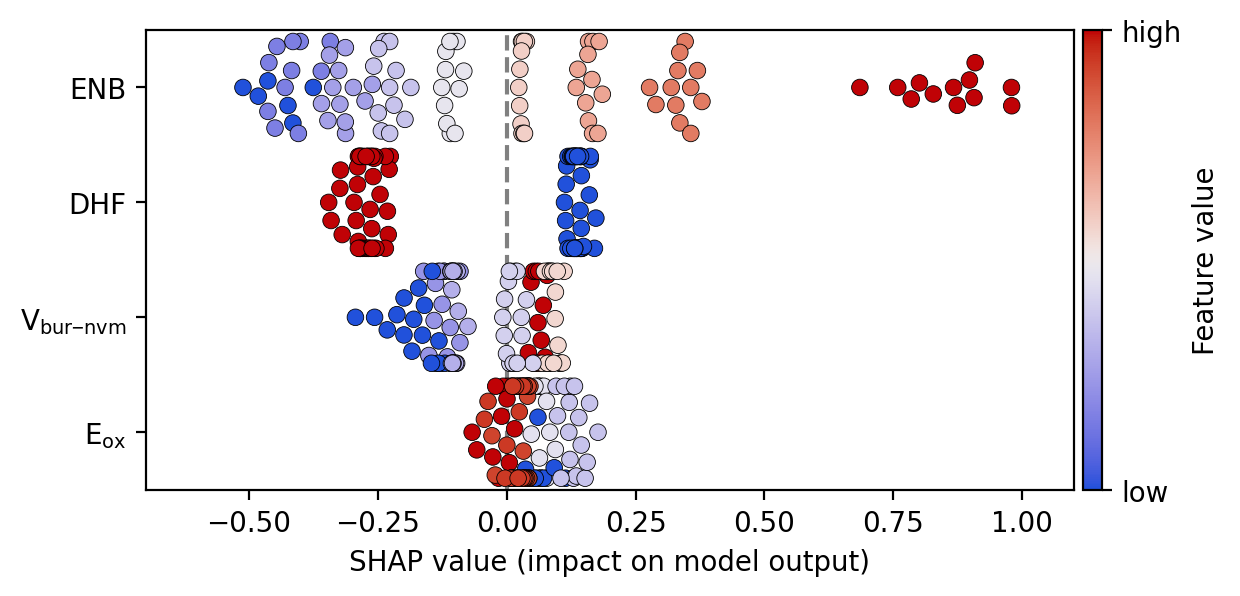

In [38]:
# TODO: clean this up

import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator

cmap = cc.cm['CET_D1']
my_dpi = 199
fig_dimensions = [6.2, 3]  # [fig_width, fig_height]
# fig_dimensions = [15, 11]  # for no overlap. can use swarmplot instead of stripplot with jitter=0.5 too
point_size = 6

ppt_conversion_x = 1  # 1.29
ppt_conversion_y = 1  # 1.33

fig_dimensions_conv = [fig_dimensions[0] *
                       ppt_conversion_x, fig_dimensions[1]*ppt_conversion_y]


# Create a DataFrame from the 2D array
df_tmp = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)
df_base_value_tmp = pd.DataFrame(
    shap_values.data, columns=shap_values.feature_names)
df_base_value_tmp = df_base_value_tmp.apply(lambda x: (
    x - x.min()) / (x.max() - x.min()) if x.dtype != 'object' else x)  # normalizes rows to be 0 to 1 for cmap

# #  Convert the DataFrame to a long format for plotting
df_tmp = df_tmp.melt(var_name='feature', value_name='SHAP_value')
df_base_value_tmp = df_base_value_tmp.melt(
    var_name='feature', value_name='feature_value')
df_tmp['feature_value'] = (df_base_value_tmp['feature_value'])

# gets an ordered feature list by importance
# Calculate the mean absolute SHAP value for each feature
feature_importance = np.mean(np.abs(shap_values.values), axis=0)
feature_importance_df = pd.DataFrame(list(zip(shap_values.feature_names, feature_importance)), columns=[
                                     'feature', 'importance'])  # Create a DataFrame mapping feature names to their importance
feature_importance_df = feature_importance_df.sort_values(
    by='importance', ascending=False)  # Sort the DataFrame by importance
order = feature_importance_df['feature'].tolist()  # Get the ordered features

# sns.swarmplot(x='SHAP_value', y='feature', data=df_tmp, hue='feature_value', order=order, legend = True, palette=cmap)


plt.close('all')
fig = plt.figure(
    figsize=(fig_dimensions_conv[0], fig_dimensions_conv[1]), dpi=my_dpi)
# Create a swarmplot without a hue
ax = sns.swarmplot(x='SHAP_value', y='feature', data=df_tmp, order=order, hue='feature_value',
                   palette=cmap, legend=False, size=point_size, edgecolor='black', linewidth=0.3, warn_thresh=0.75)

# ax = sns.stripplot(x='SHAP_value', y='feature', data=df_tmp, order=order, hue='feature_value',
#                    palette=cmap, legend=False, size=point_size, edgecolor='black', linewidth=0.3)

# Create a colormap
norm = mpl.colors.Normalize(
    vmin=df_tmp['feature_value'].min(), vmax=df_tmp['feature_value'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])


divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "2%", pad="1%")
#
# cbar = fig.colorbar(sm, cax=cax, orientation='vertical', label='feature value')

# Add a colorbar
cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
# Set the colorbar ticks and labels
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['low', 'high'])

ax.set_ylabel('')
ax.set_xlabel('SHAP value (impact on model output)')
ax.set_yticks(np.arange(len(order)))
ax.set_yticklabels(
    ['ENB', "DHF", 'V$_{\mathrm{bur\mathtt{-}nvm}}$', 'E$_{\mathrm{ox}}$'])
cbar.set_label('Feature value')
ax.axvline(0, color='grey', linestyle='--')

# ax.set_yticklabels(['ENB',"DHF",'V$_{bur-nvm}}$','E$_{\mathrm{ox}}$'])


xmin = -0.7
xmax = 1.1
base = 0.25

ax.set_xlim([xmin, xmax])
ax.xaxis.set_major_locator(MultipleLocator(base))

# plt.tight_layout()
plt.show()

In [39]:
df_non_linear_new_index_test = df_fronts_full_avg.dropna().loc[(df_fronts_full_avg['split'] == 'VS'), x_labels + [
    'Kraken_ID', 'ENB', 'DHF', 'SMILES', 'y_pred']].reset_index(drop=True)
df_non_linear_new_index_test['base_value'] = shap_values[:].base_values
i = 0

# shap_values.feature_names = X_labels
for value in shap_values.feature_names:
    # effect = base value + shap value #note data value is the kraken normalized value
    tmp_vals = [arr[i] for arr in shap_values[:].values]
    df_non_linear_new_index_test[value + '_shap_value'] = tmp_vals
    df_non_linear_new_index_test[value + '_effect'] = df_non_linear_new_index_test[value +
                                                                                  '_shap_value'] + df_non_linear_new_index_test['base_value']
    i += 1

del i, tmp_vals

In [40]:
df_non_linear_new_index_train = df_fronts_full_avg.dropna().loc[(df_fronts_full_avg['split'] == 'TS'), x_labels + [
    'Kraken_ID', 'ENB', 'DHF', 'SMILES', 'y_pred']].reset_index(drop=True)
df_non_linear_new_index_train['base_value'] = shap_values_train[:].base_values
i = 0

# shap_values.feature_names = X_labels
for value in shap_values_train.feature_names:
    # effect = base value + shap value #note data value is the kraken normalized value
    tmp_vals = [arr[i] for arr in shap_values_train[:].values]
    df_non_linear_new_index_train[value + '_shap_value'] = tmp_vals
    df_non_linear_new_index_train[value + '_effect'] = df_non_linear_new_index_train[value +
                                                                                    '_shap_value'] + df_non_linear_new_index_train['base_value']
    i += 1

del i, tmp_vals

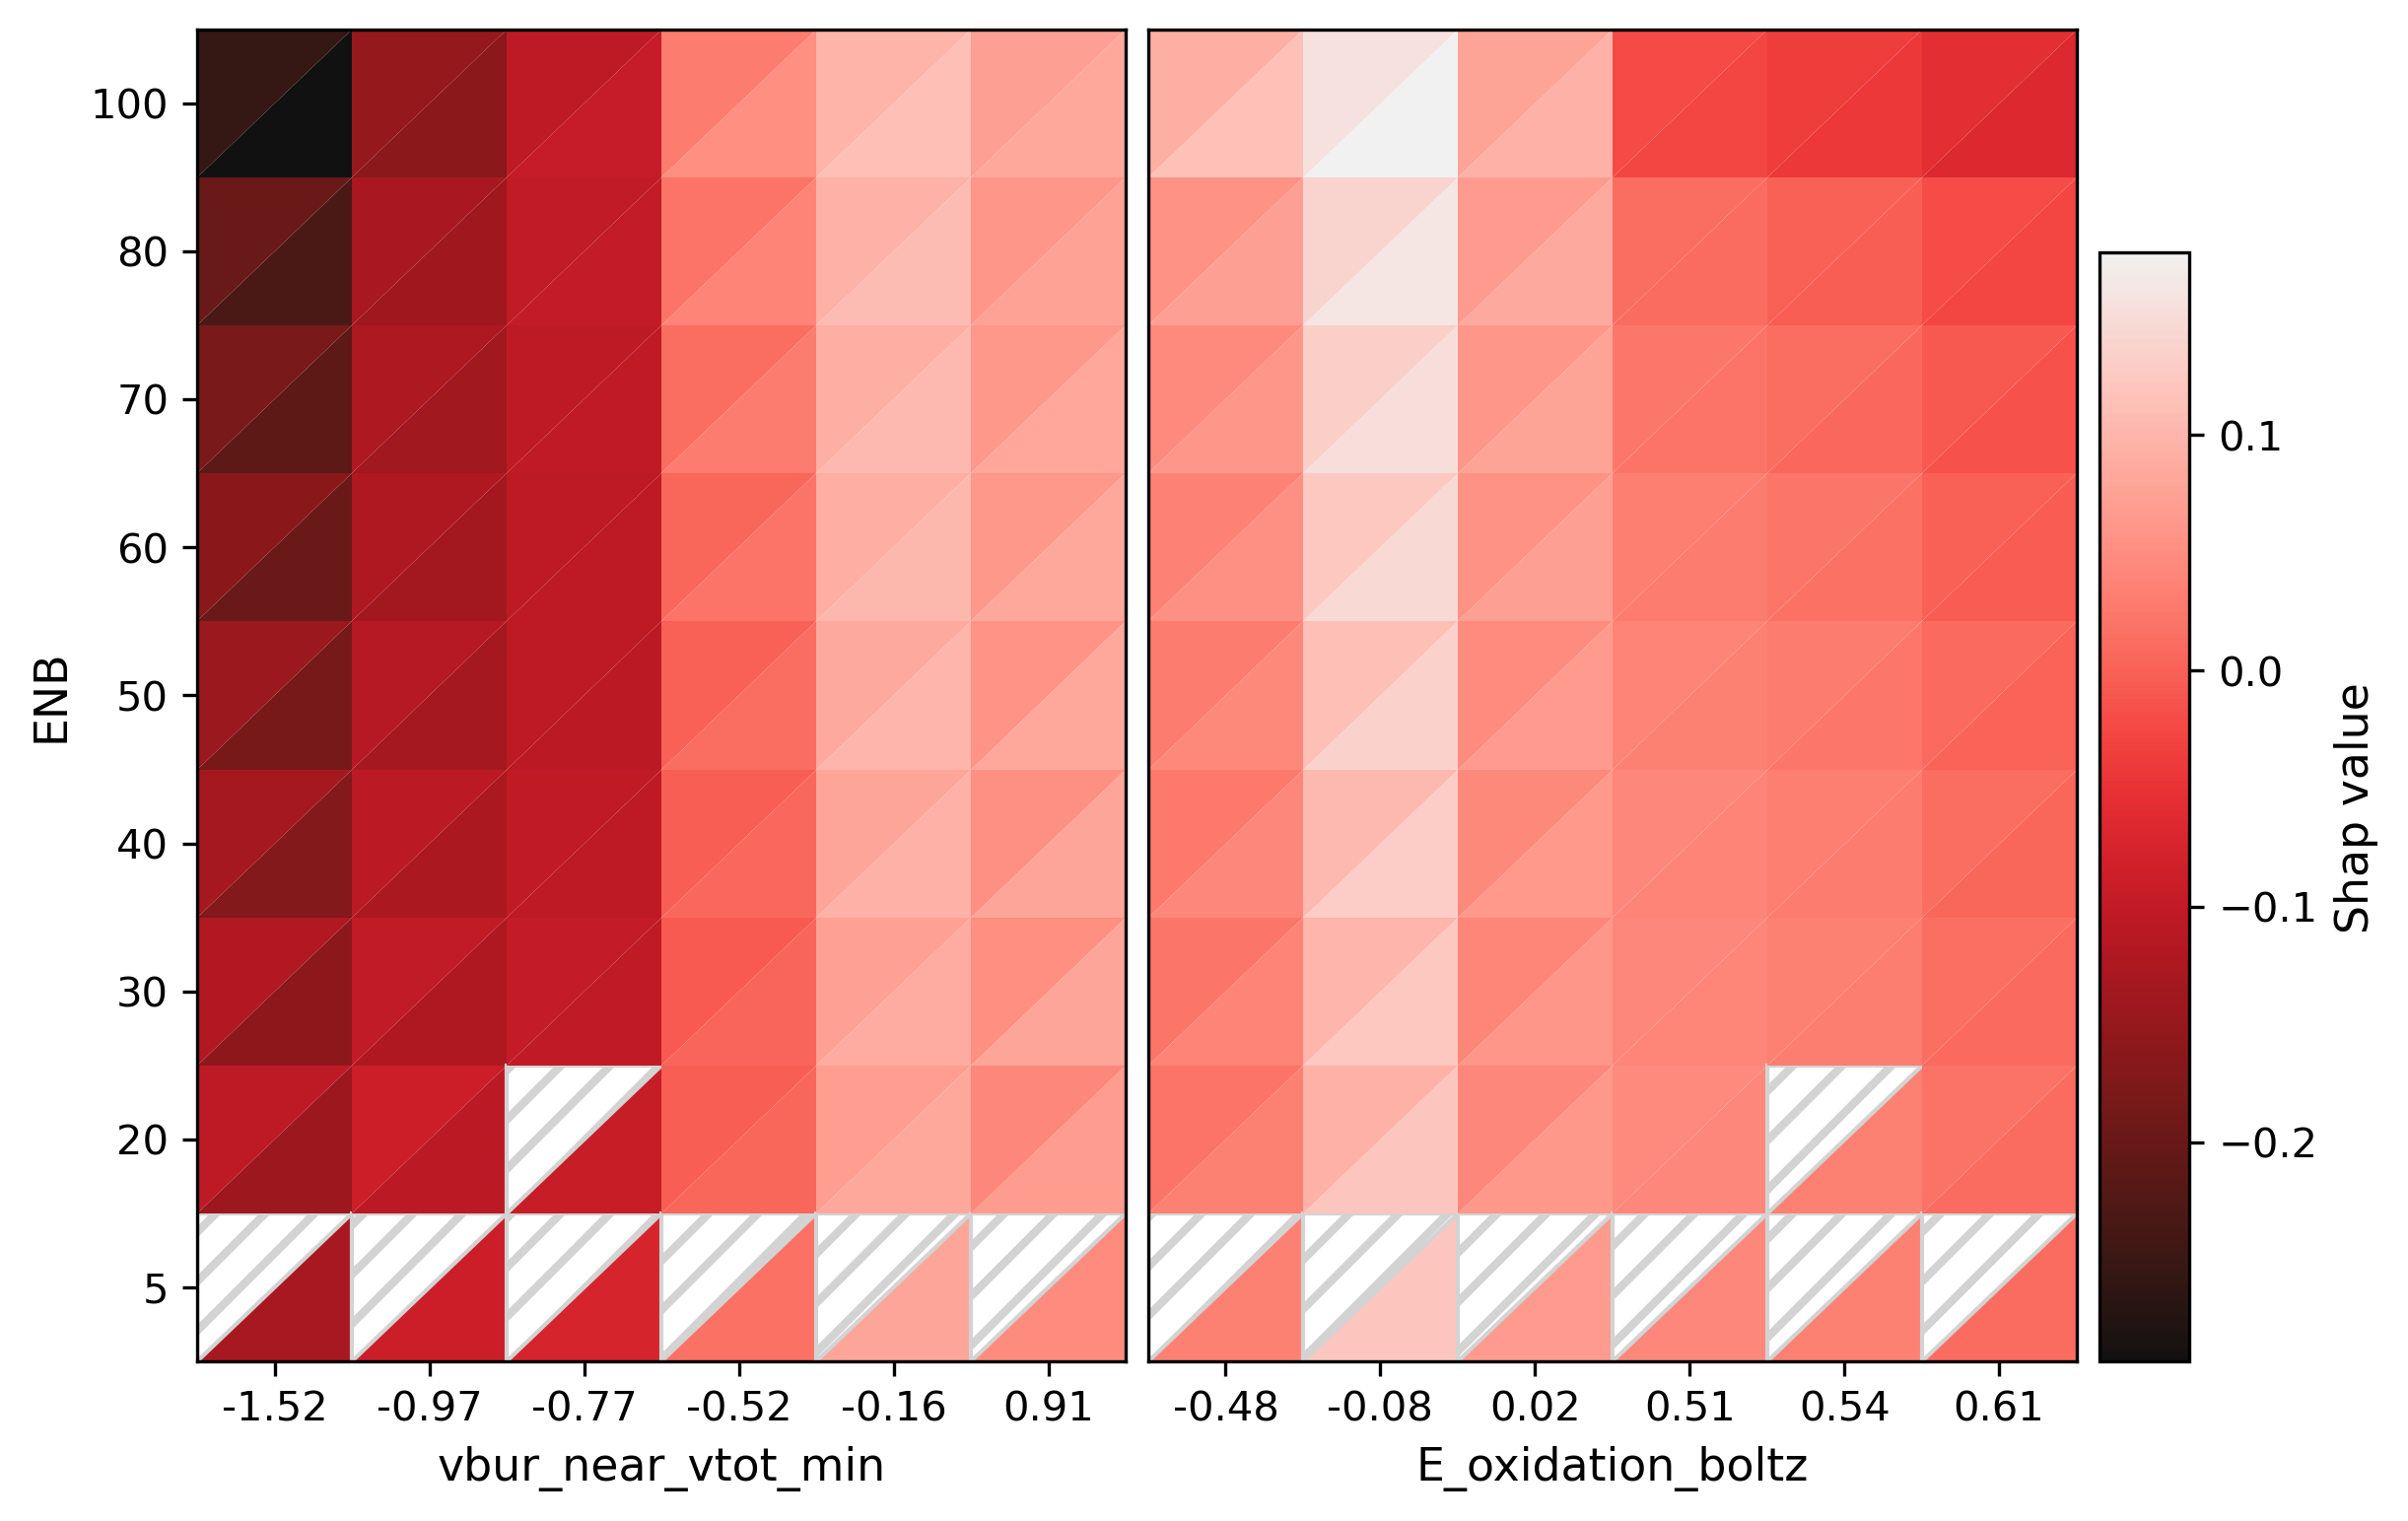

In [42]:
import matplotlib.gridspec as gridspec

# Constants
VALUES_TO_PLOT = ['x154', 'x40'] 
INDEX_NAME = "ENB"
DHF_COLUMN_NAME = 'DHF'
ENB_COLUMN_NAME = 'ENB'
ENB_ASTYPE = 'Int64'
COLOR_BAR_LABEL = 'Shap value'
AXIS_TITLE_FONT_SIZE = 11
DPI = 300
FONT_SIZE = 10
HATCH_LINEWIDTH = 2
C_MAP_NAME = cc.m_CET_CBTL4
TITLE_FONT_SIZE = 12
ORIENTATION_VERTICAL = False
FIG_SIZE = (8,5)
COLORBAR_GAP = True # the gap for the color bar is to fit molecules on the figure
COLORBAR_THICKNESS_RATIO = 0.2 # makes the colorbar thinner

# Set up plot
fig = plt.figure(figsize=FIG_SIZE, dpi=DPI)
plt.rcParams['font.size'] = FONT_SIZE
original_linewidth = plt.rcParams['hatch.linewidth'] # save the original hatch linewidth
plt.rcParams['hatch.linewidth'] = HATCH_LINEWIDTH # set the hatch linewidth
cmap = plt.get_cmap(C_MAP_NAME)
df_to_plot_tmp = df_non_linear_new_index_test.copy(deep=True)
shap_values_to_plot = [f'{value}_shap_value' for value in VALUES_TO_PLOT]
vmin = df_to_plot_tmp[shap_values_to_plot].min().min()
vmax = df_to_plot_tmp[shap_values_to_plot].max().max()
norm = plt.Normalize(vmin=vmin, vmax=vmax)



if ORIENTATION_VERTICAL:
    # plots on top of each other with colorbar on the bottom right
    # in vertical orientation the plots are wider than they are tall 
    # plotting them with more columns than rows compensates for this
    # [plot 1, plot 1, plot 1, plot 1, plot 1] | ----------
    # [plot 1, plot 1, plot 1, plot 1, plot 1] | ----------
    # -----------small gap---------------------------------
    # [plot 2, plot 2, plot 2, plot 2, plot 2] | ----------
    # [plot 2, plot 2, plot 2, plot 2, plot 2] | [colorbar]
    
    GRID_SPEC = (4, 6) # (rows, columns)
    
    GRID_SPEC_HEIGHT_RATIO = [1, 1, 1, 1]
    GRID_SPEC_WIDTH_RATIO = [1, 1, 1, 1, 1, COLORBAR_THICKNESS_RATIO]

else:
    # plots side by side with colorbar on the right
    # in horizontal orientation the plots are taller than they are wide
    # plotting them with more rows than columns compensates for this
    # [plot 1] | [plot 2]-------------
    # [plot 1] | [plot 2] | [colorbar]
    # [plot 1] | [plot 2] | [colorbar]
    # [plot 1] | [plot 2] | [colorbar]
    # [plot 1] | [plot 2] | [colorbar]
    # [plot 1] | [plot 2] | [colorbar]

    GRID_SPEC = (6, 5) # (rows, columns)
    GRID_SPEC_HEIGHT_RATIO = [1, 1, 1, 1, 1, 1]
    GRID_SPEC_WIDTH_RATIO = [1, 1, 1, 1,  COLORBAR_THICKNESS_RATIO]
    

# Grid spec
gs = gridspec.GridSpec(*GRID_SPEC, width_ratios=GRID_SPEC_WIDTH_RATIO, height_ratios=GRID_SPEC_HEIGHT_RATIO)

if ORIENTATION_VERTICAL:
    ax0 = plt.subplot(gs[0:2, 0:5])
    ax1 = plt.subplot(gs[2:4, 0:5])
    if COLORBAR_GAP:
        cax = plt.subplot(gs[3:4, 5:6])
    else:
        cax = plt.subplot(gs[0:4, 5:6])
    
else:
    ax0 = plt.subplot(gs[0:6, 0:2])
    ax1 = plt.subplot(gs[0:6, 2:4])
    if COLORBAR_GAP:
        cax = plt.subplot(gs[1:6, 4:5])
    else:
        cax = plt.subplot(gs[0:6, 4:5])

# Prepare data
# df_to_plot_tmp = df_non_linear_new_index_test.copy(deep=True)
unique_enb_array = df_to_plot_tmp[ENB_COLUMN_NAME].unique()
df_to_plot_tmp[ENB_COLUMN_NAME] = df_to_plot_tmp[ENB_COLUMN_NAME].astype(ENB_ASTYPE)

def fill_missing_enb(df, unique_enb_array):
    rows_to_add = [{ENB_COLUMN_NAME: enb, value_to_plot: value} for value in df[value_to_plot].unique() for enb in unique_enb_array if enb not in df[ENB_COLUMN_NAME].unique()]
    df = pd.concat([df, pd.DataFrame(rows_to_add)], ignore_index=True)
    df = df.sort_values(by=ENB_COLUMN_NAME)
    df[ENB_COLUMN_NAME] = df[ENB_COLUMN_NAME].astype(ENB_ASTYPE)
    return df

def plot_triangle(ax, cmap, norm, df_0, df_10, x_pos, y_pos):
    lower_triangle = patches.Polygon([[x_pos, y_pos], [x_pos+1, y_pos], [x_pos+1, y_pos+1]], closed=True,
                                     facecolor=cmap(norm(df_0[y_pos, x_pos])),
                                     hatch='//' if np.isnan(df_0[y_pos, x_pos]) else None,
                                     edgecolor='lightgrey' if np.isnan(df_0[y_pos, x_pos]) else None)
    ax.add_patch(lower_triangle)
    upper_triangle = patches.Polygon([[x_pos, y_pos], [x_pos, y_pos+1], [x_pos+1, y_pos+1]], closed=True,
                                     facecolor=cmap(norm(df_10[y_pos, x_pos])),
                                     hatch='//' if np.isnan(df_10[y_pos, x_pos]) else None,
                                     edgecolor='lightgrey' if np.isnan(df_10[y_pos, x_pos]) else None)
    ax.add_patch(upper_triangle)

def plot_data(ax, df, value_to_plot, unique_enb_array, ORIENTATION_VERTICAL):
    value_name = f"{value_to_plot}_shap_value"
    df_to_plot_tmp_0 = fill_missing_enb(df[df[DHF_COLUMN_NAME] == 0][[ENB_COLUMN_NAME, value_to_plot, value_name]], unique_enb_array)
    df_to_plot_tmp_10 = fill_missing_enb(df[df[DHF_COLUMN_NAME] == 10][[ENB_COLUMN_NAME, value_to_plot, value_name]], unique_enb_array)

    if ORIENTATION_VERTICAL:
        columns_tmp = ENB_COLUMN_NAME
        index_tmp = value_to_plot
    else:
        columns_tmp = value_to_plot
        index_tmp = ENB_COLUMN_NAME

    df_to_plot_pivot_0 = df_to_plot_tmp_0.pivot(columns=columns_tmp, index=index_tmp, values=value_name).to_numpy()
    df_to_plot_pivot_10 = df_to_plot_tmp_10.pivot(columns=columns_tmp, index=index_tmp, values=value_name).to_numpy()
    x_ticks = df[columns_tmp].unique()
    y_ticks = df[index_tmp].unique()
    x_len = len(x_ticks)
    y_len = len(y_ticks)
    for x_pos in range(x_len):
        for y_pos in range(y_len):
            plot_triangle(ax, cmap, norm, df_to_plot_pivot_0, df_to_plot_pivot_10, x_pos, y_pos)

    ax.set_xlim(0, x_len)
    ax.set_ylim(0, y_len)
    ax.set_xticks(np.arange(x_len) + 0.5)
    ax.set_yticks(np.arange(y_len) + 0.5)

    if ORIENTATION_VERTICAL:
        ax.set_yticklabels(np.around(np.sort(y_ticks), decimals=2))
        ax.set_xticklabels(x_ticks)
        ax.set_ylabel(f'{x_label_dict.get(value_to_plot)}', fontsize=AXIS_TITLE_FONT_SIZE)
        ax.set_xlabel(ENB_COLUMN_NAME, fontsize=AXIS_TITLE_FONT_SIZE)
    else:
        ax.set_yticklabels(y_ticks)
        ax.set_xticklabels(np.around(np.sort(x_ticks), decimals=2))
        ax.set_ylabel(ENB_COLUMN_NAME, fontsize=AXIS_TITLE_FONT_SIZE)
        ax.set_xlabel(f'{x_label_dict.get(value_to_plot)}', fontsize=AXIS_TITLE_FONT_SIZE)

def add_colorbar(fig, cax):
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = fig.colorbar(sm, cax=cax, shrink=0.82)
    cbar.set_label(COLOR_BAR_LABEL, fontsize=AXIS_TITLE_FONT_SIZE)

for i, value_to_plot in enumerate(VALUES_TO_PLOT):
    ax = ax0 if i == 0 else ax1
    plot_data(ax, df_to_plot_tmp, value_to_plot, unique_enb_array, ORIENTATION_VERTICAL)


if ORIENTATION_VERTICAL:
    ax0.set_xlabel("")
    ax0.set_xticks([])
else:
    ax1.set_ylabel("")
    ax1.set_yticks([])
    
plt.subplots_adjust(hspace=0, wspace=0)

add_colorbar(fig, cax)
plt.tight_layout(pad=0.2)
plt.show()


plt.rcParams['hatch.linewidth'] = original_linewidth